Enter stock symbol:  TLT
Enter start date (YYYY-MM-DD) [Default: 2023-10-05]:  now
Enter end date (YYYY-MM-DD) [Default: 2024-10-04]:  


[*********************100%***********************]  1 of 1 completed
/var/folders/sx/rpn38hd12hjb1pf2fpclw5sr0000gn/T/ipykernel_40671/3022276613.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Price: %f' % stock_data['Close'][-1])


[ 40  68  89 103 120 128 149 166 184 206 232 249]
[ 34  54  77  99 109 124 136 158 181 217 240]
days since last trough: 4 
days since last peak: 13 
[  2  11  76  95 113 133 140 163 171 185 201 228]
[  5  14  58  82 105 120 154 168 175 196 209 221 238]
days since last price trough: 25 
days since last price peak: 15 
Price: 95.665001


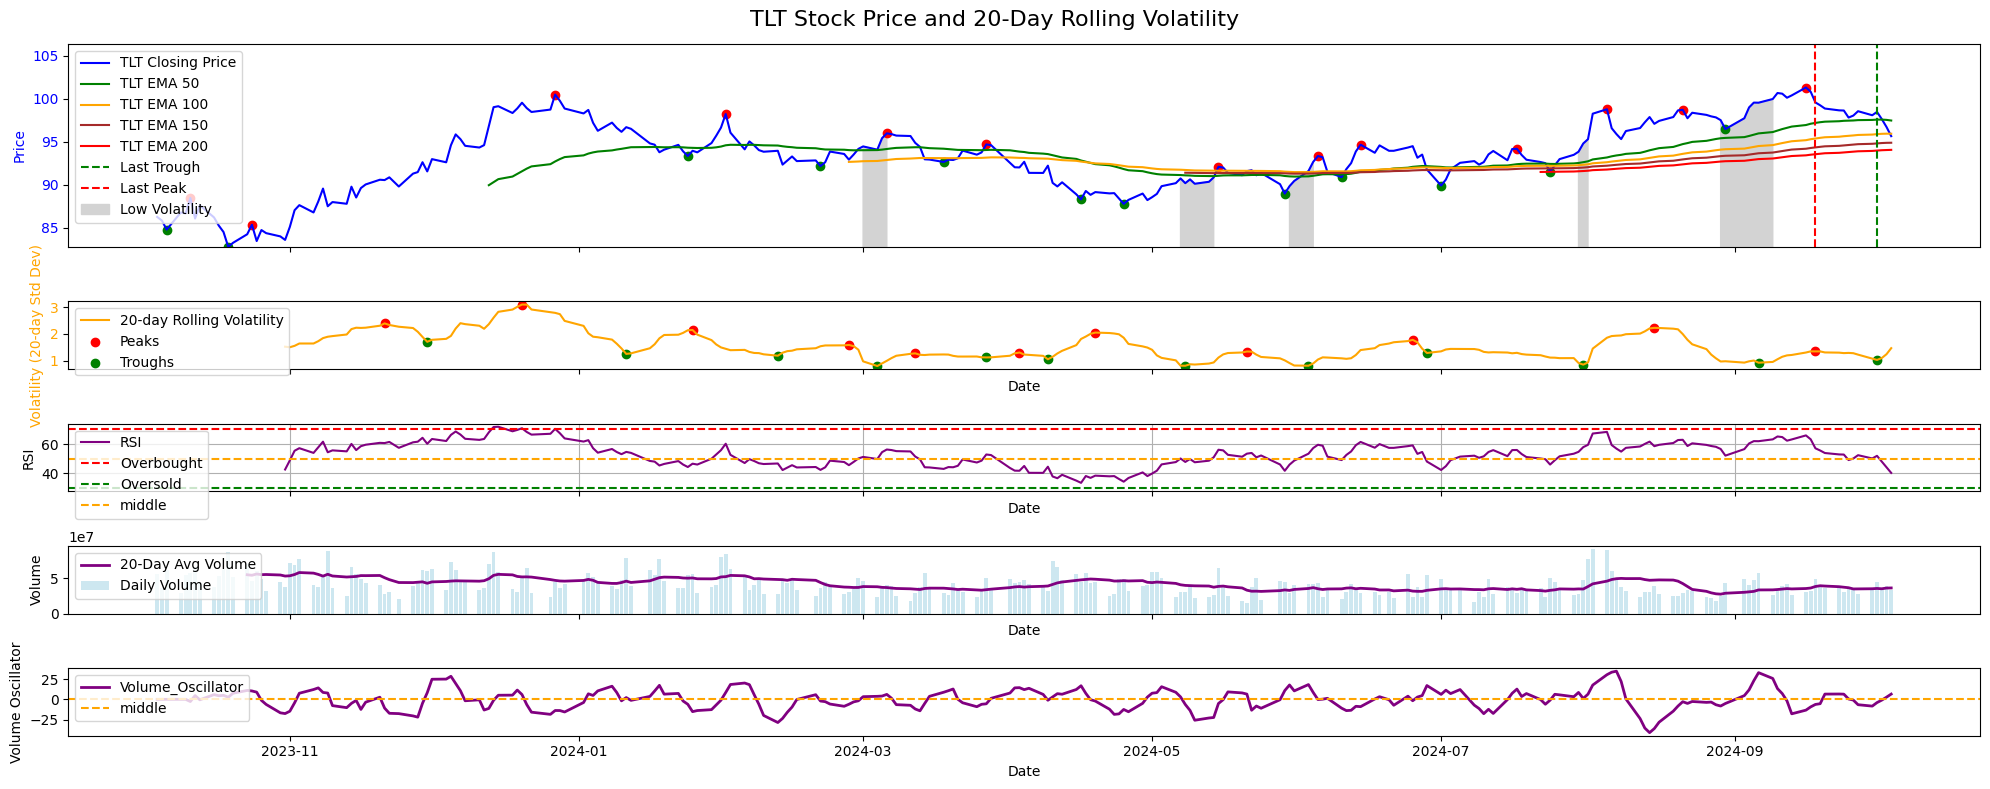

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import MultiCursor as mplcursor
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from datetime import datetime, timedelta


from ta.utils import dropna
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator
# from ta.volume import NegativeVolumeIndexIndicator

def calculate_profit(stock_symbol, local_max_indices, local_min_indices):
    # Calculate profit from trough to peak
    profits = []
    for trough_index in local_min_indices:
        # Buy price at trough
        buy_price = stock_data['Close'].iloc[trough_index]

        # Find the next peak after the trough
        for peak_index in local_max_indices:
            if peak_index > trough_index:
                # Sell price at peak
                sell_price = stock_data['Close'].iloc[peak_index]
                profit = sell_price - buy_price
                profits.append(profit)
                print(f"Buy at {buy_price:.2f} on {stock_data.index[trough_index].date()} and sell at {sell_price:.2f} on {stock_data.index[peak_index].date()}, Profit: {profit:.2f}")
                break  # Move to the next trough

    # Calculate total profit
    total_profit = sum(profits)
    print(f"\nTotal Profit from all trades: {total_profit:.2f}")   

def volume_oscillator(df, short_window=5, long_window=10):
    """
    Calculate the Volume Oscillator Index.

    Parameters:
    df (pd.DataFrame): DataFrame containing a 'Volume' column.
    short_window (int): The short period for the moving average.
    long_window (int): The long period for the moving average.

    Returns:
    pd.Series: The Volume Oscillator values.
    """
    # Calculate the short and long moving averages of the volume
    short_ma = df['Volume'].rolling(window=short_window, min_periods=1).mean()
    long_ma = df['Volume'].rolling(window=long_window, min_periods=1).mean()
    
    # Calculate the Volume Oscillator
    volume_oscillator = ((short_ma - long_ma) / long_ma) * 100  # As a percentage

    return volume_oscillator
    
def detect_volatility_breakout_and_profit(stock_symbol):
    # Step 1: Download stock data for the given symbol (1 year of daily data)
    if start_date == 'now':
        stock_data = yf.download(stock_symbol, period = "1y")
    else:
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    
    # Step 2: Calculate 20-day rolling standard deviation (volatility)
    stock_data['20d_std'] = stock_data['Close'].rolling(window=20).std()

    # Step 3: Define the low-volatility threshold (10th percentile)
    low_volatility_threshold = np.percentile(stock_data['20d_std'].dropna(), 10)

    # Step 4: Identify low-volatility periods
    stock_data['low_volatility'] = stock_data['20d_std'] < low_volatility_threshold

    # Step 5: Detect breakouts
    stock_data['price_change'] = stock_data['Close'].pct_change()
    stock_data['vol_breakout'] = (stock_data['low_volatility'].shift(1) == True) & (stock_data['low_volatility'] == False) & (stock_data['price_change'] > 0)

    # Find peaks and troughs in volatility
    local_max_indices = argrelextrema(stock_data['20d_std'].values, np.greater, order=5)[0]
    local_min_indices = argrelextrema(stock_data['20d_std'].values, np.less, order=5)[0]
 
    # local_max_indices, _ = find_peaks(stock_data['20d_std'].values, prominence=1)
    # local_min_indices, _ = find_peaks(-stock_data['20d_std'].values, prominence=1)

    local_max_price_indices = argrelextrema(stock_data['Close'].values, np.greater, order=5)[0]
    local_min_price_indices = argrelextrema(stock_data['Close'].values, np.less, order=5)[0]

    rsi = RSIIndicator(stock_data['Close'], 20).rsi()

    ema50 = EMAIndicator(stock_data['Close'],50).ema_indicator()
    ema100 = EMAIndicator(stock_data['Close'],100).ema_indicator()
    ema150 = EMAIndicator(stock_data['Close'],150).ema_indicator()
    ema200 = EMAIndicator(stock_data['Close'],200).ema_indicator()
    
    stock_data['20d_avg_volume'] = stock_data['Volume'].rolling(window=14).mean()

    stock_data['Volume_Oscillator'] = volume_oscillator(stock_data)
    # stock_data['NVI'] = NegativeVolumeIndexIndicator(stock_data['Close'], stock_data['Volume']).negative_volume_index() 

    # Create subplots (2 rows: stock price in upper pane, volatility in lower pane)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(20, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1,1,1]})

    # Plot the stock closing price
    ax1.plot(stock_data['Close'], label=f'{stock_symbol} Closing Price', color='b')
    ax1.plot(ema50, label=f'{stock_symbol} EMA 50', color='green')
    ax1.plot(ema100, label=f'{stock_symbol} EMA 100', color='orange')
    ax1.plot(ema150, label=f'{stock_symbol} EMA 150', color='brown')
    ax1.plot(ema200, label=f'{stock_symbol} EMA 200', color='red')
    
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.axvline(x=stock_data.index[local_min_indices[-1]], color='green', linestyle='--', label='Last Trough')
    ax1.axvline(x=stock_data.index[local_max_indices[-1]], color='red', linestyle='--', label='Last Peak')
    ax1.fill_between(stock_data.index, stock_data['Close'], where=stock_data['low_volatility'], color='lightgray', label='Low Volatility')
    ax1.legend(loc='upper left')
    ax1.set_ylim(bottom=stock_data['Close'].min())

    # Plot peaks and troughs
    ax1.scatter(stock_data.index[local_max_price_indices], stock_data['Close'].iloc[local_max_price_indices], color='red', marker='o', label='Peaks')
    ax1.scatter(stock_data.index[local_min_price_indices], stock_data['Close'].iloc[local_min_price_indices], color='green', marker='o', label='Troughs')


    last_idx = len(stock_data)
    
    print(local_min_indices)
    print(local_max_indices)
    print('days since last trough: %d ' % (last_idx - local_min_indices[-1]))
    print('days since last peak: %d '% (last_idx - local_max_indices[-1]))

    print(local_min_price_indices)
    print(local_max_price_indices)
    print('days since last price trough: %d ' % (last_idx - local_min_price_indices[-1]))
    print('days since last price peak: %d '% (last_idx - local_max_price_indices[-1]))
    print('Price: %f' % stock_data['Close'][-1])
  
    # Plot the rolling volatility
    ax2.plot(stock_data['20d_std'], label='20-day Rolling Volatility', color='orange')

    # Plot peaks and troughs
    ax2.scatter(stock_data.index[local_max_indices], stock_data['20d_std'].iloc[local_max_indices], color='red', marker='o', label='Peaks')
    ax2.scatter(stock_data.index[local_min_indices], stock_data['20d_std'].iloc[local_min_indices], color='green', marker='o', label='Troughs')

    ax2.set_ylabel('Volatility (20-day Std Dev)', color='orange')
    ax2.set_xlabel('Date')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.legend(loc='upper left')

    # Add title to the figure
    fig.suptitle(f'{stock_symbol} Stock Price and 20-Day Rolling Volatility', fontsize=16)

    ax3.plot(stock_data.index, rsi, label='RSI', color='purple')
    ax3.axhline(70, color='red', linestyle='--', label='Overbought')
    ax3.axhline(30, color='green', linestyle='--', label='Oversold')
    ax3.axhline(50, color='orange', linestyle='--', label='middle')
    ax3.set_ylabel('RSI')
    ax3.set_xlabel('Date')
    ax3.legend(loc='upper left')
    ax3.grid(True)

    # Plot the volume and 20-day average volume
    ax4.bar(stock_data.index, stock_data['Volume'], label='Daily Volume', color='lightblue', alpha=0.6)
    ax4.plot(stock_data.index, stock_data['20d_avg_volume'], label='20-Day Avg Volume', color='purple', linewidth=2)

    ax4.set_ylabel('Volume')
    ax4.set_xlabel('Date')
    ax4.legend(loc='upper left')

    # Plot the volume oscillator
    ax5.plot(stock_data.index, stock_data['Volume_Oscillator'], label='Volume_Oscillator', color='purple', linewidth=2)
    ax5.axhline(0, color='orange', linestyle='--', label='middle')
    ax5.set_ylabel('Volume Oscillator')
    ax5.set_xlabel('Date')
    ax5.legend(loc='upper left')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Input: Enter a stock symbol (like 'MSFT', 'AAPL', etc.)
user_input = input("Enter stock symbol: ").upper()
ticker_list = [ticker.strip() for ticker in user_input.split(',')]  # Process the input
default_end_date = datetime.today().strftime('%Y-%m-%d')
default_start_date = (datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d')

# Get user input with defaults
start_date = input(f"Enter start date (YYYY-MM-DD) [Default: {default_start_date}]: ") or default_start_date
end_date = input(f"Enter end date (YYYY-MM-DD) [Default: {default_end_date}]: ") or default_end_date


for i, ticker in enumerate(ticker_list):
    detect_volatility_breakout_and_profit(ticker)
